In [39]:
import pandas as pd
import os 
import numpy as np
from nilmtk import DataSet

year = '2014'
month = '2'
filename = 'mains.csv'

UK_DALE = '../../Datasets/UKDALE/ukdale.h5'
END = "{}-28-{}".format(month, year)
START = "{}-1-{}".format(month, year)
train_building = 1
DEVICE = None

def get_main_data(start, end, sample_period=6, buidling=1):
    dataset = DataSet(UK_DALE)
    dataset.set_window(start=start, end=end)
    elec = dataset.buildings[buidling].elec
    if DEVICE is not None:
        mains = elec.submeters()[DEVICE]
    else:
        mains = elec.mains()
    main_power = mains.power_series_all_data(sample_period=sample_period)
    df_main = pd.DataFrame(main_power)
    df_main.replace('NaN', 0, inplace=True)
    return df_main
    
df = get_main_data(START, END)

FOLDER_PATH = '/media/christoforos/DATA/signal2vec/vectorized_sequences/{}/{}'.format(year, month)
df_vectorized = pd.read_csv(FOLDER_PATH + '/' + filename)

print('Shape of original data: {}'.format(df.shape))
print('Shape of vectorized data: {}'.format(df_vectorized.shape))

window = 20

array = df_vectorized.values
print('Shape of array: {}'.format(array.shape))

array = np.reshape(array, (len(array)/window, window, 300))
a = [i for i in range(window)]
a = np.reshape(a, (1, window, 1))
sum_of_vectors = np.sum(a*array, axis=1)
print('Shape of array in windows: {}'.format(array.shape))
print('Shape of array after summing windows: {}'.format(sum_of_vectors.shape))


Shape of original data: (388800, 1)
Shape of vectorized data: (388800, 300)
Shape of array: (388800, 300)
Shape of array in windows: (19440, 20, 300)
Shape of array after summing windows: (19440, 300)


                  0
count  19440.000000
mean      11.926132
std       13.948860
min        0.000000
25%        0.000000
50%        4.000000
75%       24.000000
max       41.000000
19440
MultiIndex(levels=[[u'power'], [u'active']],
           labels=[[0], [0]])


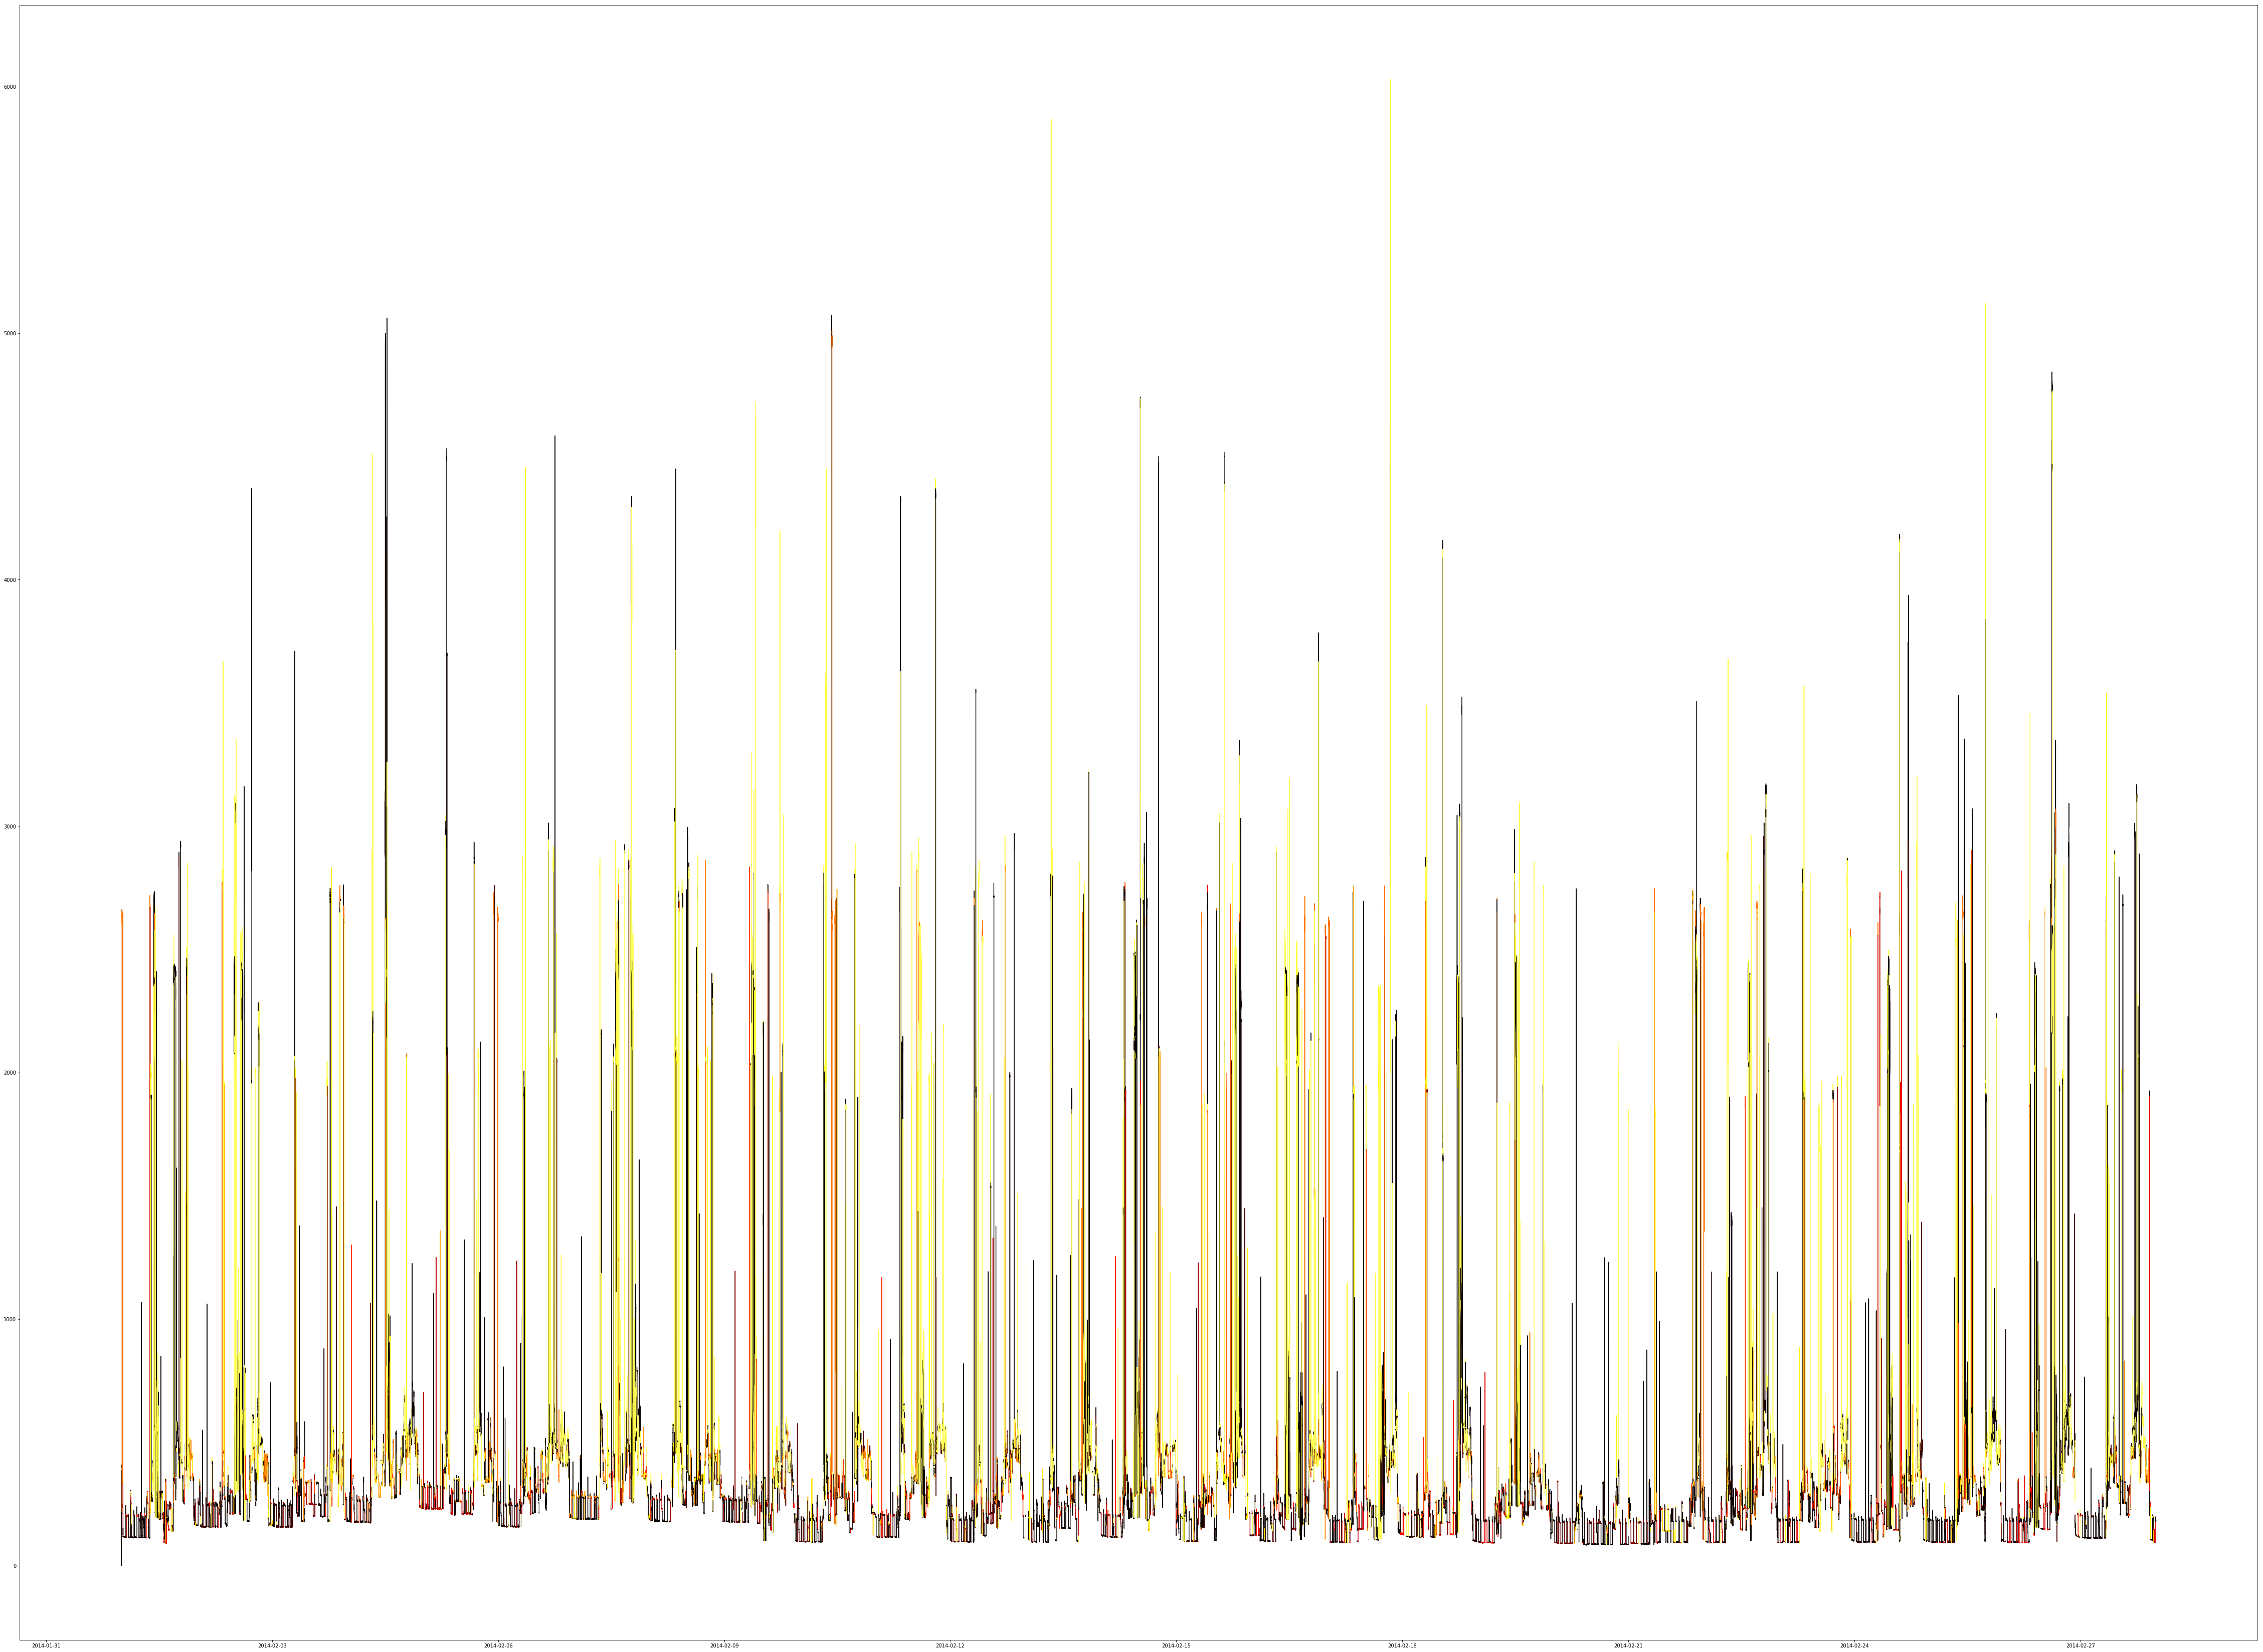

In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib as mpl

pred = KMeans(n_clusters=42, random_state=13).fit_predict(sum_of_vectors)
pred_df = pd.DataFrame(pred)
print(pred_df.describe())
print(len(pred))
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
print(df.columns)

norm = mpl.colors.Normalize(vmin=min(pred), vmax=max(pred))
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.clf()
# plt.figure(figsize=(5, 4), dpi=80)

# for i in range(len(sum_of_vectors)):
#     path = '/media/christoforos/DATA/signal2vec/clustering/{}/{}/{}'.format(year, month, pred[i])
#     if not os.path.exists(path):
#         os.makedirs(path)
#     plt.plot(df[i*window:(i+1)*window])
#     plt.savefig(path + '/{}'.format(str(i*window) + '_' + 
#                                     str((i+1)*window)) + '.png')
#     plt.clf()

#     if pred[i] == 3:
#         print('Index {} - prediction {}'.format(i, pred[i]))
#         plt.plot(df[i*window:(i+1)*window], c=pred[i])
#         plt.show()
#         plt.clf()

plt.figure(figsize=(80, 60))
for i in range(len(sum_of_vectors)):
    p = pred[i]
    
    plt.plot(df[i*window:(i+1)*window], c=m.to_rgba(p))

path = '/media/christoforos/DATA/signal2vec/clustering/{}/{}'.format(year, month)
if not os.path.exists(path):
    os.makedirs(path)
if DEVICE:
    plt.savefig(path + '/{}_{}'.format('clustered', DEVICE) + '.png')
else:
    plt.savefig(path + '/{}'.format('clustered') + '.png')


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(sum_of_vectors)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pred, cmap='viridis')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

X_reduced = PCA(n_components=3).fit_transform(sum_of_vectors)

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=pred,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])